In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from crepes import WrapRegressor
from mapie.regression import MapieRegressor
from copy import copy
import time

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Conformal prediction

In this notebook, we will use conformal prediction to add a prediction interval to a point prediction model. We will start by computing this manually for understanding. Afterwards examples are given of the 2 most used python packages: crepes and MAPIE.

In this notebook:
1. [Input](#input)
2. [Conformal prediction manually for understanding](#manual)
3. [Conformal prediction with package crepes](#crepes)
4. [Conformal prediction with package MAPIE, with default settings (different result)](#MAPIE-cross-val)
5. [Conformal prediction with package MAPIE, without cross-validation](#MAPIE)
6. [Comparison of results: manual, crepes and MAPIE](#comparison)

Information about the crepes and MAPIE packages:
* https://crepes.readthedocs.io/en/latest/crepes.html
* https://mapie.readthedocs.io/en/latest/

As explained in more detail in the presentation, this prediction interval is added to any point forecast:

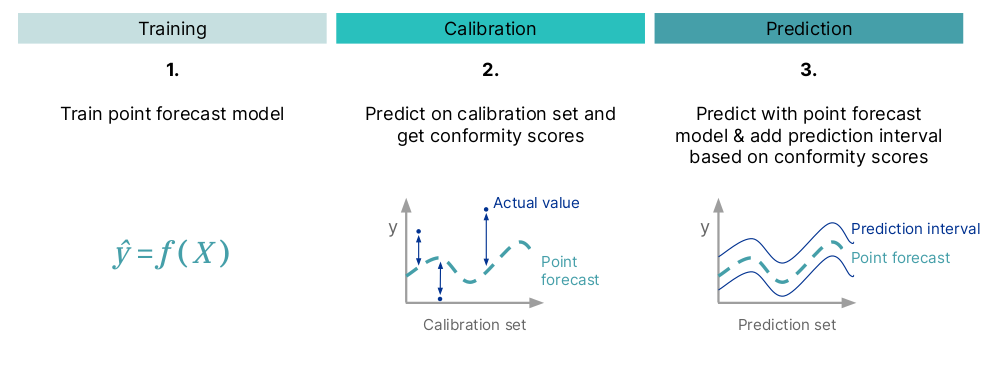

# 1. Input <a class="anchor" id="input"></a>

Here you can select the confidence level of your prediction interval.

In [11]:
# Create a dataset
dataset = fetch_openml(name="house_sales", version=3, parser="auto")
X = dataset.data.values.astype(float)
y = dataset.target.values.astype(float)

# Split train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split train and calibration set
X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train a point prediction model as a baseline
baseline_model = LGBMRegressor()
fitted_baseline_model = copy(baseline_model).fit(X_prop_train, y_prop_train)

# Choose your confidence level of the prediction interval
confidence = 0.9

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2371
[LightGBM] [Info] Number of data points in the train set: 13832, number of used features: 21
[LightGBM] [Info] Start training from score 538033.585816


In [12]:
# Some functionality

def plot_impression_of_subset(point, interval):
    plt.plot(point)
    plt.plot(interval)
    plt.legend(['Point prediction', 'Lower bound of prediction interval', 'Upper bound of prediction interval'])
    plt.xlabel('Impression of subset of samples')
    plt.ylabel('y')

# 2. Conformal prediction manually for understanding <a class="anchor" id="manual"></a>

In this part a list of conformity scores is created. From the conformity scores, the relevant quantile is selected to obtain the correction factor.

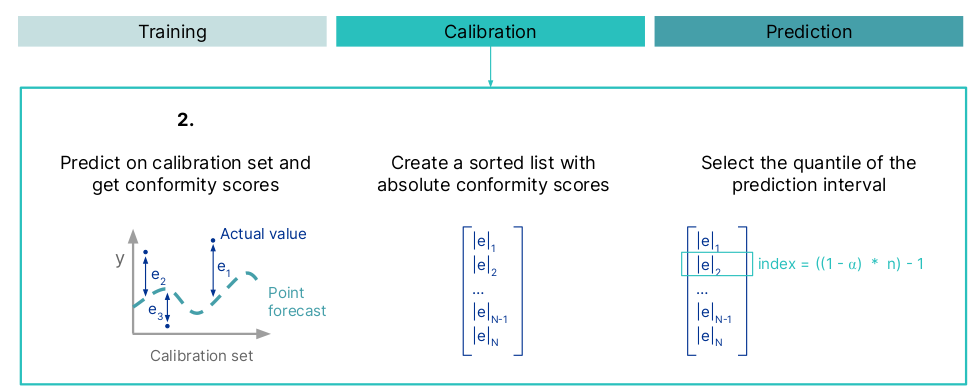

In [14]:
# Predict on calibration set to compute the conformity scores
point_prediction_cal = fitted_baseline_model.predict(X_cal)
residuals = y_cal - point_prediction_cal
conformity_scores = np.abs(residuals)
conformity_scores.sort()

# Compute the correction factor based on the selected confidence level
correction_factor_index = int(len(conformity_scores) * (1 - confidence))
correction_factor = conformity_scores[correction_factor_index]

# Prediction: point prediction with prediction interval
point_prediction = fitted_baseline_model.predict(X_test)
prediction_intervals = np.zeros((len(point_prediction),2))
prediction_intervals[:,0] = point_prediction - correction_factor
prediction_intervals[:,1] = point_prediction + correction_factor

# Note: if alpha_index = 0: interval is [-np.inf, np.inf], in that case the number of calibration samples is too small for the chosen confidence level

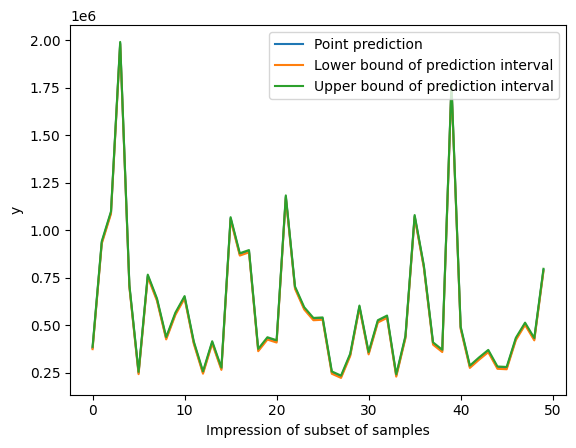

In [15]:
plot_impression_of_subset(point_prediction[:50], prediction_intervals[:50, :])

# 3. Conformal prediction with package crepes <a class="anchor" id="crepes"></a>
In this example the crepes package is used to add a prediction interval to our point prediction.

Note: the learner (e.g. RandomForestRegressor) can be fit both before and after being wrapped.

In [16]:
start_crepes = time.time()

crepes_model = WrapRegressor(baseline_model)
crepes_model.fit(X_prop_train, y_prop_train)
crepes_model.calibrate(X_cal, y_cal)
crepes_point_prediction = crepes_model.predict(X_test)
crepes_prediction_intervals = crepes_model.predict_int(X_test, confidence=confidence)

end_crepes = time.time()

print(f"\n Crepes computation time in seconds: {end_crepes-start_crepes}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2371
[LightGBM] [Info] Number of data points in the train set: 13832, number of used features: 21
[LightGBM] [Info] Start training from score 538033.585816

 Crepes computation time in seconds: 0.47559642791748047


# 4. Conformal prediction with package MAPIE, with default settings (different result) <a class="anchor" id="MAPIE-cross-val"></a>

In this example the MAPIE package is used to add a prediction interval to our point prediction. By default MAPIE uses a 5-fold cross-validation. As input to determine the confidence interval, alpha is used. An alpha value of 0.05 gives a 95% confidence interval.

In [17]:
mapie_model = MapieRegressor(baseline_model)
mapie_model.fit(X_train, y_train)
mapie_point_prediction, mapie_prediction_intervals = mapie_model.predict(X_test, alpha=1-confidence)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2379
[LightGBM] [Info] Number of data points in the train set: 17290, number of used features: 21
[LightGBM] [Info] Start training from score 537768.047947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2366
[LightGBM] [Info] Number of data points in the train set: 13832, number of used features: 21
[LightGBM] [Info] Start training from score 535992.459442
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

# 5. Conformal prediction with package MAPIE, without cross-validation <a class="anchor" id="MAPIE"></a>

To compare the results of crepes and MAPIE, the default settings of crepes are selected for MAPIE. By selecting the prefitted model, the cross-validation step is skipped.

In [18]:
start = time.time()

mapie_prefit_model = MapieRegressor(fitted_baseline_model, cv='prefit')
mapie_prefit_model.fit(X_cal, y_cal)
mapie_prefit_point_prediction, mapie_prefit_prediction_intervals = mapie_prefit_model.predict(X_test, alpha=1-confidence)

end = time.time()

print(f"MAPIE computation time in seconds: {end-start}")

MAPIE computation time in seconds: 0.046143531799316406


# 6. Comparison of results: manual, crepes and MAPIE <a class="anchor" id="comparison"></a>

The plots below show that all methods behave as expected and give the same results. The package that is most suitable for your project, depends on the goal of the project:

- **Crepes package**: best suited for simpler tasks. Faster for simple tasks and next to that, the underlying code of the crepes package is easier to read if you want to have a more detailed look at it.
- **MAPIE package**: best suited for more extensive tasks. More extensive and offers many possibilities to step into more complex methods, combined with good documentation.

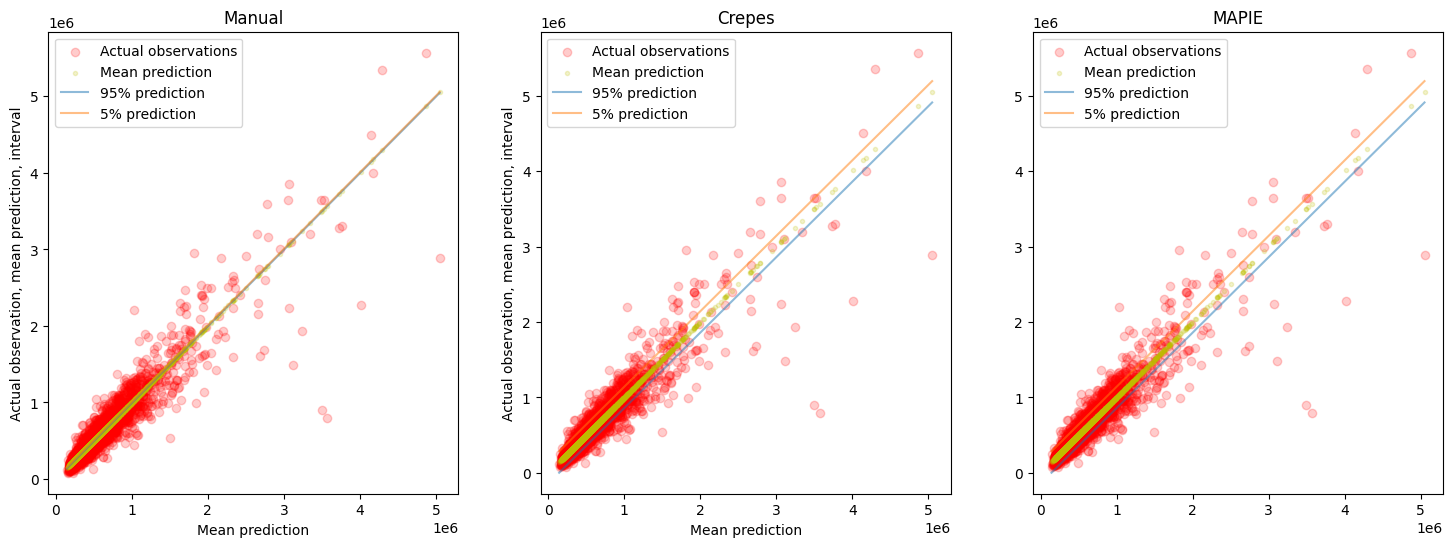

In [19]:
fig, axs = plt.subplots(1,3, figsize=(18,6))

sorted_index = np.argsort(point_prediction)

axs[0].set_title('Manual')
axs[0].scatter(point_prediction, y_test, color='r', alpha=0.2, label='Actual observations')
axs[0].scatter(point_prediction, point_prediction, color='y', marker=".", alpha=0.2, label='Mean prediction')
axs[0].plot(point_prediction[sorted_index], prediction_intervals[sorted_index,0], alpha=0.5, label='95% prediction')
axs[0].plot(point_prediction[sorted_index], prediction_intervals[sorted_index,1], alpha=0.5, label='5% prediction')
axs[0].set_xlabel('Mean prediction')
axs[0].set_ylabel('Actual observation, mean prediction, interval')
axs[0].legend()


axs[1].set_title('Crepes')
axs[1].scatter(crepes_point_prediction, y_test, color='r', alpha=0.2, label='Actual observations')
axs[1].scatter(crepes_point_prediction, crepes_point_prediction, color='y', marker=".", alpha=0.2, label='Mean prediction')
axs[1].plot(crepes_point_prediction[sorted_index], crepes_prediction_intervals[sorted_index,0], alpha=0.5, label='95% prediction')
axs[1].plot(crepes_point_prediction[sorted_index], crepes_prediction_intervals[sorted_index,1], alpha=0.5, label='5% prediction')
axs[1].set_xlabel('Mean prediction')
axs[1].set_ylabel('Actual observation, mean prediction, interval')
axs[1].legend()

axs[2].set_title('MAPIE')
axs[2].scatter(mapie_prefit_point_prediction, y_test, color='r', alpha=0.2, label='Actual observations')
axs[2].scatter(mapie_prefit_point_prediction, mapie_prefit_point_prediction, color='y', marker=".", alpha=0.2, label='Mean prediction')
axs[2].plot(mapie_prefit_point_prediction[sorted_index], np.array(mapie_prefit_prediction_intervals)[sorted_index,0], alpha=0.5, label='95% prediction')
axs[2].plot(mapie_prefit_point_prediction[sorted_index], np.array(mapie_prefit_prediction_intervals)[sorted_index,1], alpha=0.5, label='5% prediction')
axs[2].legend()

In [22]:
y_test_in_prediction_interval = (y_test >= prediction_intervals[:, 0]).astype(int) * (y_test <= prediction_intervals[:, 1]).astype(int)
print(f'Percentage of test set within prediction interval with {confidence}: {y_test_in_prediction_interval.mean() * 100:.2f}%')

y_test_in_mapie_prediction_interval = (y_test >= mapie_prediction_intervals[:, 0].squeeze()).astype(int) * (y_test <= mapie_prediction_intervals[:, 1].squeeze()).astype(int)
print(f'Percentage of test set within prediction interval of the MapieRegressor with {confidence}: {y_test_in_mapie_prediction_interval.mean() * 100:.2f}%')


Percentage of test set within prediction interval with 0.9: 8.26%
Percentage of test set within prediction interval of the MapieRegressor with 0.9: 91.30%



When comparing the methods on performance, the crepes package is faster:

In [23]:

print(f"Crepes package is {(end - start) / (end_crepes - start_crepes):.2f} times faster")

Crepes package is 0.10 times faster


Do you want to explore more? A good point to start is comparing alternative methods for the `MapieRegressor` [(link to docs)](https://mapie.readthedocs.io/en/latest/generated/mapie.regression.MapieRegressor.html).